In [ ]:
import fastai.vision.all as vision
from PIL import Image
import torch

import numpy as np
import torch.nn.functional as F
# from fastbook import *

from meanclassifier import MeanClassifier

In [ ]:
def image_to_tensor(img_file):
    img = Image.open(img_file)
    as_array = np.array(img)
    as_tensor = torch.from_numpy(as_array)
    return as_tensor

In [ ]:
path = vision.untar_data(vision.URLs.MNIST_SAMPLE)

train_threes = (path/'train'/'3').ls().sorted()
train_threes = [image_to_tensor(img) for img in train_threes]
train_threes = torch.stack(train_threes).float() / 255

train_sevens = (path/'train'/'7').ls().sorted()
train_sevens = [image_to_tensor(img) for img in train_sevens]
train_sevens = torch.stack(train_sevens).float() / 255

test_threes = (path/'valid'/'3').ls().sorted()
test_threes = [image_to_tensor(img) for img in test_threes]
test_threes = torch.stack(test_threes).float() / 255

test_sevens = (path/'valid'/'7').ls().sorted()
test_sevens = [image_to_tensor(img) for img in test_sevens]
test_sevens = torch.stack(test_sevens).float() / 255

X_train = torch.cat((train_sevens, train_threes))
y_train = torch.from_numpy(np.array([0] * len(train_sevens) + [1] * len(train_threes)))

X_test = torch.cat((test_sevens, test_threes))
y_test = torch.from_numpy(np.array([0] * len(test_sevens) + [1] * len(test_threes)))

mae: 0.9514229893684387
mse: 0.9661432504653931


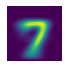

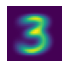

In [ ]:
mae_clf = MeanClassifier(metric='mae')
mae_clf.fit(X_train, y_train)
mae_clf.show_means()

mse_clf = MeanClassifier(metric='mse')
mse_clf.fit(X_train, y_train)
print(f'mae: {mae_clf.score(X_test, y_test)}')
print(f'mse: {mse_clf.score(X_test, y_test)}')

In [ ]:
t = torch.Tensor([3.]).requires_grad_()

In [ ]:
def f(x):
    return x ** 2

yt = f(t)
yt

xt = torch.Tensor([3.]).requires_grad_()
yt = f(xt)
yt

tensor([9.], grad_fn=<PowBackward0>)

In [ ]:
yt.backward()


In [ ]:
yt.backward()
yt.grad

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations.
  


In [ ]:
xt.grad


tensor([6.])

In [ ]:
yt.backward()


/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations.
  """Entry point for launching an IPython kernel.


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=d3089e79-0e42-40a4-9bfd-5171fd4144aa' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>